<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%205/B1_GRU_Time_Series_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# GRU en series temporales
En este  cuaderno, vamos a aprender a configurar y a explorar el comportamiento de una red neuronal recurrente GRU, que como sabemos es una versión mejorada del concepto de red recurrente, con una arquitectura interna modificada de forma que evite los principales problemas encontrados en las redes neuronales recurrentes simples. 

Vamos a emplear datos de la Federal Reserve Economic Database (FRED) referido a ventas de Cerveza, Vino bebidas alcohólicas Destiladas en millones de dólares de Enero 1992 a Enero 2019 (325 registros).

Fuente de datos: https://fred.stlouisfed.org/series/S4248SM144NCEN

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Cargar el conjunto de datos
Aprovecharemos las ventajas de la función de pandas <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> pasando <tt>parse_dates=True</tt>

In [3]:
#df = pd.read_csv('/content/sample_data/Alcohol_Sales.csv',index_col=0,parse_dates=True)
df = pd.read_csv('https://raw.githubusercontent.com/vicentcamison/idal_ia3/main/3%20Aprendizaje%20profundo%20(II)/Sesion%205/Alcohol_Sales.csv', index_col=0, parse_dates=True)
len(df)

325

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


## Trazado de datos de series temporales
Podemos añadir títulos, etiquetas en los ejes y otras características al gráfico.<br>
Vamos a ajustar el eje x para que se adapte al ancho de los datos reales con <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternativamente podrías establecer tus propios límites con <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01'))</tt> o algunos otros valores.

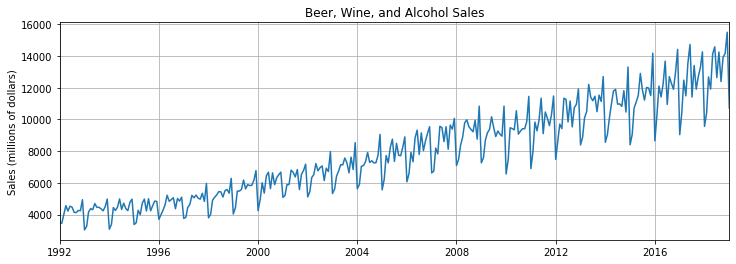

In [6]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Preparar los datos
En los siguientes pasos: 
* dividiremos los datos en conjuntos de entrenamiento/prueba, 
* normalizaremos los valores de entrenamiento para que estén entre -1 y 1 (para mejorar el entrenamiento)
* entrenaremos el modelo y, a continuación, 
* predeciremos en un periodo que coincida con el conjunto de pruebas. 
* Por último, haremos una previsión para un futuro desconocido.

In [7]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalizar los datos
La fórmula para normalizar los datos en torno a cero es:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
donde $\mu$ es la media de la población, y $\sigma$ es la desviación estándar de la población.<br>

Lo que queremos realizar es un <a href='https://en.wikipedia.org/wiki/Feature_scaling'>escalado mínimo/máximo de características</a> para que nuestros valores caigan entre -1 y 1, ya que esto hace que los hiperparámetros converjan más rápido.<br>La fórmula para esto sería:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} 
{X_{max} - X_{min}}$

donde $a={-1}$ y $b=1$<br>


Podemos utilizar scikit-learn para hacer esto, con <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTA: Sólo queremos normalizar el conjunto de entrenamiento para evitar la fuga de datos. Si incluimos el conjunto de pruebas, los valores medios más altos del conjunto de pruebas podrían convertirse en parte de la señal del conjunto de entrenamiento. Hay un buen artículo sobre la fuga de datos <a href='conjunto_de_prueba = datos_de_entrada(norma_de_prueba,tamaño_de_ventana)'> aquí</a>.

Después de utilizar los datos transformados para entrenar el modelo y generar predicciones, transformaremos_inversamente los valores predichos para poder compararlos con los datos de prueba reales.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [11]:
train_norm.min()

-1.0

In [12]:
train_norm.max()

1.0

In [13]:
train_norm.mean()

-0.2041940178388313

In [14]:
type(train_norm)

numpy.ndarray

## Preparar los datos para GRU
Aquí crearemos nuestra lista de tuplas (seq/label) del conjunto de entrenamiento. Recordemos que una GRU consume una ventana de muestras hacia la primera predicción, por lo que el tamaño de nuestro conjunto de entrenamiento se convertirá en ((325 - test_size) - window_size).

In [15]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  

301

In [16]:
# Display the first seq/label tuple in the train data
train_data[1]

(tensor([-0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128,
         -0.7901, -0.7933, -0.6743, -1.0000]), tensor([-0.9607]))

## Definir el modelo
Utilizaremos una capa GRU de tamaño (1,100).

In [17]:
class GRUnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Capa GRU:
        self.gru = nn.GRU(input_size,hidden_size)
             
        # Capa fully-connected:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialización h0:
        self.hidden = (torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        gru_out, self.hidden = self.gru(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(gru_out.view(len(seq),-1))
        return pred[-1]  # solo queremos el último valor

## Instanciar el modelo, definir las funciones de pérdida y optimización

In [18]:
torch.manual_seed(101)
model = GRUnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Para ver los detalles del modelo creado en Pytorch lo hacemos directamente llamando al modelo:

In [19]:
model

GRUnetwork(
  (gru): GRU(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

Y para contar los parámetros definimos una función:

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   300
 30000
   300
   300
   100
     1
______
 31001


## Entrenamiento del modelo

In [21]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extraemos secuencia y label de los training data
    for seq, y_train in train_data:
        
        # reseteo de parametros ay estados ocultos
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # Imprimo log
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.31638145
Epoch:  2 Loss: 0.36562097
Epoch:  3 Loss: 0.37781179
Epoch:  4 Loss: 0.35362667
Epoch:  5 Loss: 0.32944912
Epoch:  6 Loss: 0.34529534
Epoch:  7 Loss: 0.27918559
Epoch:  8 Loss: 0.13047765
Epoch:  9 Loss: 0.04066433
Epoch: 10 Loss: 0.00292992
Epoch: 11 Loss: 0.00080598
Epoch: 12 Loss: 0.00434816
Epoch: 13 Loss: 0.00029772
Epoch: 14 Loss: 0.00001135
Epoch: 15 Loss: 0.00020355
Epoch: 16 Loss: 0.00039809
Epoch: 17 Loss: 0.00050835
Epoch: 18 Loss: 0.00051879
Epoch: 19 Loss: 0.00043806
Epoch: 20 Loss: 0.00029434
Epoch: 21 Loss: 0.00013164
Epoch: 22 Loss: 0.00001430
Epoch: 23 Loss: 0.00003706
Epoch: 24 Loss: 0.00033376
Epoch: 25 Loss: 0.00106372
Epoch: 26 Loss: 0.00230913
Epoch: 27 Loss: 0.00378315
Epoch: 28 Loss: 0.00459677
Epoch: 29 Loss: 0.00406651
Epoch: 30 Loss: 0.00277224
Epoch: 31 Loss: 0.00160506
Epoch: 32 Loss: 0.00084514
Epoch: 33 Loss: 0.00041559
Epoch: 34 Loss: 0.00018234
Epoch: 35 Loss: 0.00006056
Epoch: 36 Loss: 0.00000803
Epoch: 37 Loss: 0.00000175
E

## Ejecuta las predicciones y compáralas con el conjunto de pruebas conocido

In [22]:
future = 12

# Añade la última ventana de valores de entrenamiento a la lista de predicciones
preds = train_norm[-window_size:].tolist()

# Poner el modelo en modo de evaluación
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [23]:
# Muestra predicciones
preds[window_size:]    # equivalente a preds[-future:]

[0.3398492634296417,
 0.5335741639137268,
 0.4975498914718628,
 0.7706154584884644,
 0.8305383920669556,
 0.4778534471988678,
 0.7327569723129272,
 0.5624668598175049,
 0.6917235851287842,
 0.6842139959335327,
 0.9496729373931885,
 0.1636156141757965]

## Invertir la normalización
Queremos comparar nuestras predicciones de prueba con los datos originales, así que tenemos que deshacer el paso de normalización anterior. Tenga en cuenta que <tt>inverse_transform</tt> utiliza los parámetros aplicados más recientemente; podemos reescalar basándonos en los datos de prueba, pero no en los datos de entrenamiento anteriores.

In [24]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10868.44826643],
       [12001.64207181],
       [11790.91809016],
       [13388.21512443],
       [13738.7343244 ],
       [11675.70373939],
       [13166.76190954],
       [12170.6498965 ],
       [12926.73711121],
       [12882.80976921],
       [14435.61184728],
       [ 9837.56953512]])

In [25]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

¿Que te parecen las predicciones? 

## Representar los resultados
Nuestros datos originales contienen un índice datetime, pero nuestros valores predichos no. Podemos crear un rango de fechas usando NumPy que estén espaciadas un mes entre sí usando <tt>dtype='datetime64[M]'</tt>, y luego almacenarlas con valores de día para que coincidan con nuestro conjunto de datos con <tt>.astype('datetime64[D]')</tt>.

In [26]:
# Recuerda que la fecha de parada tiene que ser posterior al último valor previsto.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

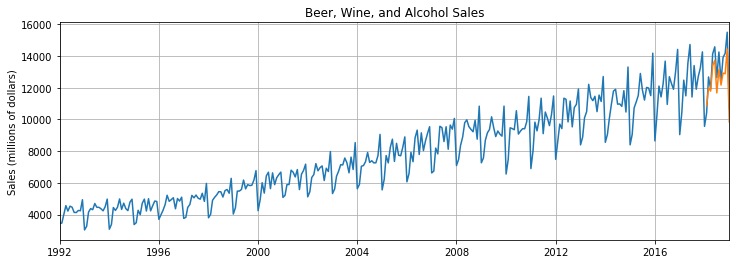

In [27]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

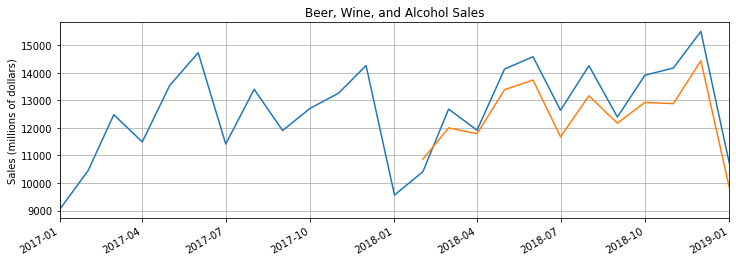

In [28]:
# Ploteamos la parte final del gráfico (zoom)
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Seleccionamos a partir de 01-01-2017:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

# Predicción de futuro desconocido
Para lanzar predicciones sobre datos nuevos desconocidos, una posibilidad empleada es continuar entrenando el modelo utilizando todo el conjunto de datos, y lanzar las predicciones, en nuestro caso 12 pasos en el futuro.

In [29]:
epochs = 100

# Ponemos el modelo en modo entrenamiento
model.train()

# escalamos y pasamos a Torch tensor
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # entrenamos para toda la secuencia
    for seq, y_train in all_data:  
        
        # reset de parameteros y estado oculto
        optimizer.zero_grad()

        model.hidden = (torch.zeros(1,1,model.hidden_size))    
        
        # prediccion
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # resultado
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00987486
Epoch:  2 Loss: 0.00524633
Epoch:  3 Loss: 0.00560206
Epoch:  4 Loss: 0.00470607
Epoch:  5 Loss: 0.00515463
Epoch:  6 Loss: 0.00522810
Epoch:  7 Loss: 0.00590002
Epoch:  8 Loss: 0.00574568
Epoch:  9 Loss: 0.00595544
Epoch: 10 Loss: 0.00579833
Epoch: 11 Loss: 0.00656416
Epoch: 12 Loss: 0.00535542
Epoch: 13 Loss: 0.00422948
Epoch: 14 Loss: 0.00562285
Epoch: 15 Loss: 0.00420107
Epoch: 16 Loss: 0.00355015
Epoch: 17 Loss: 0.00976495
Epoch: 18 Loss: 0.00349174
Epoch: 19 Loss: 0.00718086
Epoch: 20 Loss: 0.00191103
Epoch: 21 Loss: 0.00676234
Epoch: 22 Loss: 0.00171173
Epoch: 23 Loss: 0.01056721
Epoch: 24 Loss: 0.00399628
Epoch: 25 Loss: 0.00492532
Epoch: 26 Loss: 0.00901987
Epoch: 27 Loss: 0.00862430
Epoch: 28 Loss: 0.00515752
Epoch: 29 Loss: 0.00339236
Epoch: 30 Loss: 0.00478002
Epoch: 31 Loss: 0.00203593
Epoch: 32 Loss: 0.00133915
Epoch: 33 Loss: 0.00050261
Epoch: 34 Loss: 0.00070911
Epoch: 35 Loss: 0.00153611
Epoch: 36 Loss: 0.00000025
Epoch: 37 Loss: 0.00937837
E

## Ploteamos las predicciones

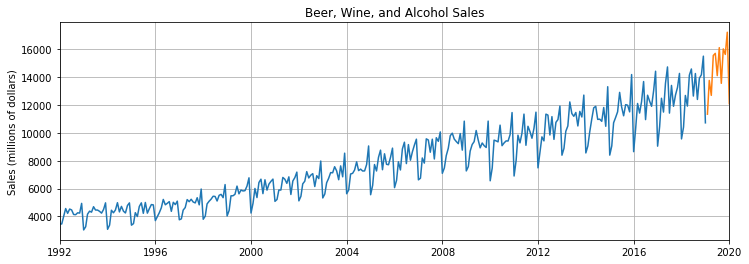

In [30]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reseteamos los parametros aqui
        model.hidden = (torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

#Normalización inversa del conjunto de predicciones
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOTEAMOS EL RESULTADO
# Establezca un rango de datos para los datos predichos.
# Recuerde que la fecha de parada tiene que ser posterior al último valor predicho.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

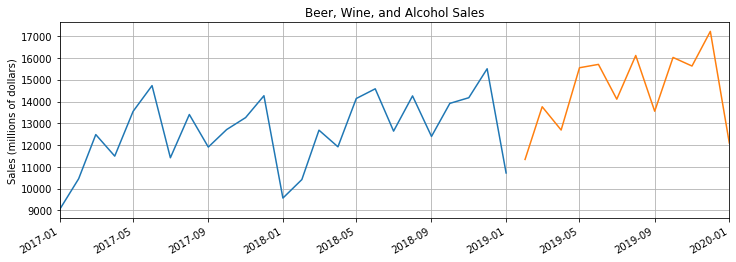

In [31]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

Enhorabuena, has llegado al final del cuaderno. 




## Referencias

*   Documento inspirado en el curso UDEMY: DeepLearning con Pytorch de Jose Marcial Portilla.
* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

##Fin del cuaderno